This kernel uses data from [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview)

**DATA PREPARATION**

We start with loading packages and setting seeds to 0 for reproducible results

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# set all seed to 0
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

We import data from csv file and split it into 3 groups: training - for our models training, validation - for models' evaluation  and tuning hyperparametrs during training, testing - for evaluation of the final model.

In [3]:
from pathlib import Path

# read data
src_dir = Path ('C:/Labs/')
all_data = pd.read_csv(src_dir / "fer2013.csv")

In [4]:
# split to 3 parts
groups = [g for _, g in all_data.groupby('Usage')]
training_data = groups[2]
validation_data = groups[1]
testing_data = groups[0]

As last step of data preparation, we process groups: transform Dataframes to DataLoader and reshape images array from 1D to 2D. At the same time data will be moved to GPU if it is available:

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def make_dataloader(data, batch_size, shuffle):
    images, labels = data['pixels'], data['emotion']
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in images]) / 255.0 # normalizing data to be between 0 and 1
    images = torch.FloatTensor(images.reshape(images.shape[0], 1, 48, 48)).to(device) # 1 color channel, 48x48 images
    dataset = torch.utils.data.TensorDataset(images, torch.LongTensor(np.array(labels)).to(device))
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [6]:
train_loader = make_dataloader(training_data, 100, True)
valid_loader = make_dataloader(validation_data, 100, False)

Let's look at data:

Angry


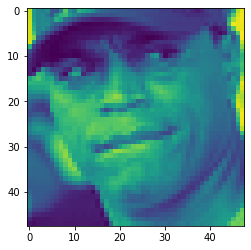

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(label_names[labels[1]])
plt.imshow(images[1].view(48, 48).cpu());

**MODELS TRAINING**

In this project we will be using ResNet models from torchvision package.
Models will be trained in two steps:
    1. ResNet18 model trained with different learning rate
    2. ResNet50 and ResNet152 models trained with learning rate that showed the best result with ResNet18
For all models, we will be using CrossEntropyLoss loss function and SGD optimizer.
Results of training of different models will be compared and the best performing one will be selected for final tests.

We will need to change the first convolutional layer and the last fully connected layer n the loaded models to fit our data (1 color channel for pictures and 7 classes).

In [8]:
import torch.nn as nn
def adjust_model(model):
    model.conv1 = nn.Conv2d(1, 64, model.conv1.kernel_size, model.conv1.stride, model.conv1.padding, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7, bias=False)
    return model

Each model will be trained with 100 epoches

In [9]:
epochs = 100

In [10]:
def eval_model(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        loss = 0
        for data, labels in data_loader:
            output = model(data)
            _, preds = torch.max(output.data, 1)
            equals = (preds == labels).cpu()
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            loss += criterion(output, labels).data.cpu()
        return accuracy/len(data_loader), loss/len(data_loader)
        
def train_model(model, criterion, optimizer, data_loader, eval_loader):
    model = model.to(device)
    test_accuracy_history = []
    test_loss_history = []
    for epoch in trange(epochs):
        model.train()
        for data, labels in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        accuracy, loss = eval_model(model, eval_loader, criterion)
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss)
    return test_accuracy_history, test_loss_history

**PART1: Same model - different learning rate**

We start with ResNet18 model and five different learning rates:

In [11]:
from torch import optim
from torchvision import models
criterion = nn.CrossEntropyLoss()
lrs = [0.1, 0.01, 0.001, 0.0001, 0.000001]
models_1 = [adjust_model(models.resnet18()) for i in range(len(lrs))]
optimizers = [optim.SGD(models_1[i].parameters(), lr=lrs[i], momentum=0.9) for i in range(len(lrs))]

In [12]:
for i in range(len(lrs)):
    print(f"lr={lrs[i]}")
    accuracy, loss = train_model(models_1[i], criterion, optimizers[i], train_loader, valid_loader)
    torch.save(accuracy, src_dir / ('ResNet18_lr_'+ str(lrs[i]) + '_accuracy.pt'))
    torch.save(loss, src_dir / ('ResNet18_lr_'+ str(lrs[i]) + '_loss.pt'))
    torch.save(models_1[i], src_dir/ ('ResNet18_lr_'+ str(lrs[i]) + '_model.pt'))

lr=0.1



lr=0.01



lr=0.001



lr=0.0001



lr=1e-06


Since it takes very long time to train model, it was done offline and the results were saved in files, that we can load now.

In [13]:
resnet18_accuracy = [torch.load(src_dir / "ResNet18_lr_0.1_accuracy.pt"), 
            torch.load(src_dir / "ResNet18_lr_0.01_accuracy.pt"),
            torch.load(src_dir / "ResNet18_lr_0.001_accuracy.pt"),
            torch.load(src_dir / "ResNet18_lr_0.0001_accuracy.pt"),
            torch.load(src_dir / "ResNet18_lr_1e-06_accuracy.pt")]

resnet18_loss = [torch.load(src_dir / "ResNet18_lr_0.1_loss.pt"),
                 torch.load(src_dir / "ResNet18_lr_0.01_loss.pt"),
                 torch.load(src_dir / "ResNet18_lr_0.001_loss.pt"),
                 torch.load(src_dir / "ResNet18_lr_0.0001_loss.pt"),
                 torch.load(src_dir / "ResNet18_lr_1e-06_loss.pt")]

From the loss data we can see, that first model reach minimum loss at epoch 11. The second and third models reach minimum losses at 3d and 4th epochs. Even though loss starts to increase after this, the accuracy with the validation set is also growing for all three models. The model with 0.1 learning rate shows the best accuracy of all models - 57.81%.
The model with 0.0001 learing rate has minimum loss at epoch 19, and model with least learning rate of 1e-06 doesn't reach minimum (the loss will keep going down if we increase number of epochs).

The results show that lower learning rate results in lower accuracy with ResNet18:

In [14]:
colors = ['skyblue', 'red', 'green', 'violet', 'magenta']

def make_plots(accuracy, losses, title1, title2, lbls):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text(title1)
    for i in range(len(accuracy)):
        ax1.plot(range(epochs),accuracy[i], color=colors[i],label=lbls[i])
    ax1.set_xlabel('epochs');
    ax1.set_ylabel('accuracy')
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.title.set_text(title2)
    for i in range(len(losses)):
        ax2.plot(range(epochs),losses[i], color=colors[i],label=lbls[i])
    ax2.set_xlabel('epochs');
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper left')
    plt.subplots_adjust(wspace=0.35, right=2.0)
    plt.show()

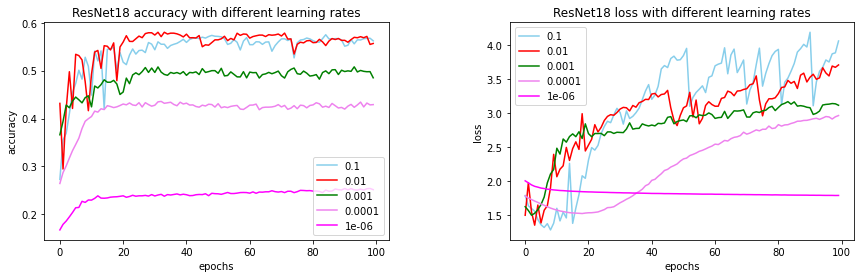

In [15]:
title1 = 'ResNet18 accuracy with different learning rates'
title2 = 'ResNet18 loss with different learning rates'
make_plots(resnet18_accuracy, resnet18_loss, title1, title2, [str(lr) for lr in lrs])

In [16]:
def print_acc_loss_results(name_tag, var_s, accs, losses):
    min_inds = []
    print("Min losses:")
    for i in range (len(losses)):
        min_v = min(losses[i])
        min_ind = losses[i].index(min_v)
        min_inds.append(min_ind)
        print(name_tag + ' {}: Loss {:.5f} at the epoch # {}'.format(var_s[i],min_v, min_ind+1))
    print("\nResulting accuracies:")
    for i in range (len(accs)):
        print(name_tag + ' {}: Accuracy {:.2f}'.format(var_s[i],np.mean(accs[i][-10:-1]) * 100.0))
    print("\nAccuracies at minimal loss epoch:")
    for i in range (len(accs)):
        print(name_tag + ' {}: Accuracy {:.2f} at the epoch # {}'.format(var_s[i],accs[i][min_inds[i]] * 100, min_inds[i]+1))

In [17]:
print_acc_loss_results('Learning rate', lrs, resnet18_accuracy, resnet18_loss)

Min losses:
Learning rate 0.1: Loss 1.27632 at the epoch # 9
Learning rate 0.01: Loss 1.34605 at the epoch # 4
Learning rate 0.001: Loss 1.49288 at the epoch # 3
Learning rate 0.0001: Loss 1.51750 at the epoch # 19
Learning rate 1e-06: Loss 1.78317 at the epoch # 99

Resulting accuracies:
Learning rate 0.1: Accuracy 56.16
Learning rate 0.01: Accuracy 56.56
Learning rate 0.001: Accuracy 49.95
Learning rate 0.0001: Accuracy 42.73
Learning rate 1e-06: Accuracy 25.23

Accuracies at minimal loss epoch:
Learning rate 0.1: Accuracy 52.79 at the epoch # 9
Learning rate 0.01: Accuracy 49.77 at the epoch # 4
Learning rate 0.001: Accuracy 42.80 at the epoch # 3
Learning rate 0.0001: Accuracy 42.43 at the epoch # 19
Learning rate 1e-06: Accuracy 25.40 at the epoch # 99


**PART2: ResNet50 and ResNet152 models with best learning rate**

The learning rate of 0.1 showed best results with ResNet18. We will use it to train ResNet50 and ResNet152 models and compare results with previously trained ResNet18 at the same learning rate.

In [18]:
models_2 = [adjust_model(models.resnet50()), adjust_model(models.resnet152())]
optimizers_2 = [optim.SGD(models_2[i].parameters(), lr=0.1, momentum=0.9) for i in range(2)]
names = ['ResNet50', 'ResNet152']

In [19]:
for i in range(len(names)):
    accuracy, loss = train_model(models_2[i], criterion, optimizers_2[i], train_loader, valid_loader)
    torch.save(accuracy, src_dir / (names[i] + '_0.1_accuracy.pt'))
    torch.save(loss, src_dir / (names[i] + '_0.1_loss.pt')) 
    torch.save(models_2[i], src_dir / (names[i] + '_0.1_model.pt'))

ResNet50 and ResNet152 showed worse results compared to ResNet18: resulting accuracy was 48.3.79% and 49.75% for ResNet50 and ResNet152 respectivly.

In [25]:
resnet50_152_accuracy = [torch.load(src_dir / "ResNet50_0.1_accuracy.pt"), 
            torch.load(src_dir / "ResNet152_0.1_accuracy.pt")]

resne50_152_loss = [torch.load(src_dir / "ResNet50_0.1_loss.pt"),
                 torch.load(src_dir / "ResNet152_0.1_loss.pt")]

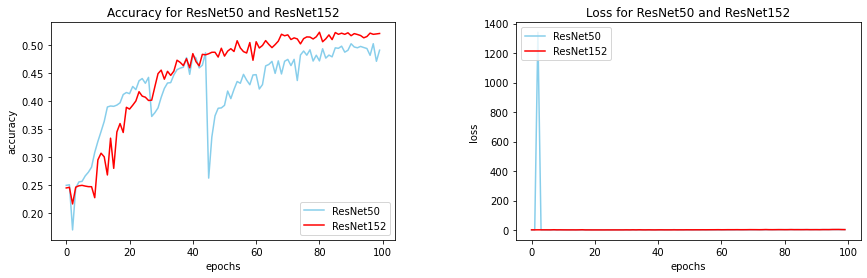

In [26]:
title1 = 'Accuracy for ResNet50 and ResNet152'
title2 = 'Loss for ResNet50 and ResNet152'
make_plots(resnet50_152_accuracy, resne50_152_loss, title1, title2, names)

In [27]:
print_acc_loss_results('Model', names, resnet50_152_accuracy, resne50_152_loss)

Min losses:
Model ResNet50: Loss 1.44970 at the epoch # 38
Model ResNet152: Loss 1.49544 at the epoch # 24

Resulting accuracies:
Model ResNet50: Accuracy 49.33
Model ResNet152: Accuracy 51.85

Accuracies at minimal loss epoch:
Model ResNet50: Accuracy 46.08 at the epoch # 38
Model ResNet152: Accuracy 41.68 at the epoch # 24


**Testing best model on Test dataset**

ResNet18 with learning rate 0.1 showed best results on validation dataset. Therefore it was chosen as our final model and will be tested with test dataset 

In [29]:
test_loader = make_dataloader(testing_data, 100, False)
model_best = torch.load(src_dir / 'ResNet18_lr_0.1_model.pt')
acc, losses = eval_model(model_best, test_loader, criterion)

In [30]:
print('Test accuracy: ' + str(acc*100))

Test accuracy: 56.92509338259697


The test accuracy of ResNet18 model trained with 0.1 learing rate on FER2013 dataset is 58.6%.